#### Purpose: To test if functions in `mgtwr` package can reproduce similar results obtained in `GWmodel`

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

#### Load data and reproject it to projected coordinate system

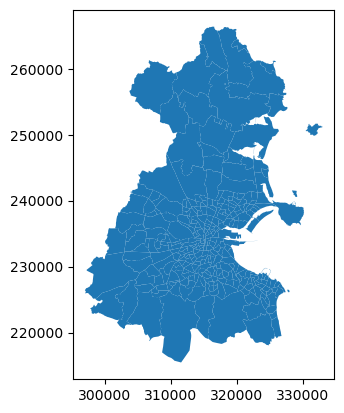

In [2]:
gdf = gpd.read_file("Dub.voter.geojson")
gdf.set_crs(epsg=29902, inplace=True, allow_override=True)
gdf.plot()
plt.show()

In [3]:
gdf.head(5), gdf.columns

(   DED_ID            X            Y    DiffAdd     LARent        SC1  \
 0  2001.0  314791.6914  235243.9827  22.086331  16.208791   8.561151   
 1  2002.0  314417.7765  234933.7849  23.599871  22.388060   7.898996   
 2  2003.0  314253.1357  234162.8824  33.515789  75.438596  10.610526   
 3  2004.0  313676.5355  234506.9246  13.959184  37.298637   5.469388   
 4  2005.0  313956.8117  234737.2759  13.886975  13.615870   6.960717   
 
       Unempl   LowEduc   Age18_24   Age25_44   Age45_64  GenEl2004  \
 0   8.009709  0.600000  24.172662  39.568345  12.302158  48.891353   
 1  12.126156  0.585586  21.884105  45.483975  15.118161  41.010943   
 2   8.940201  0.522648  28.042105  49.684211   9.389474  45.035461   
 3  15.185602  0.698758  14.666667  39.292517  16.571429  52.616822   
 4  13.021807  0.579581  11.957271  38.042729  19.469331  57.308684   
 
                                             geometry  
 0  MULTIPOLYGON (((315137.389 235866.579, 315131....  
 1  MULTIPOLYGON (((

### perform GWR

In [4]:
# get coordinates
coords = gdf[["X", "Y"]]

# extract independent variables
X = gdf[['DiffAdd', 'LARent', 'SC1', 'Unempl', 'LowEduc', 'Age18_24', 'Age25_44', 'Age45_64']]

# extract dependent variable
y = gdf[["GenEl2004"]]

In [5]:
from mgtwr.sel import SearchGWRParameter
from mgtwr.model import GWR

"""
SearchGWRParameter(
    coords: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    X: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    y: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    kernel: str = 'exponential',
    fixed: bool = False,
    constant: bool = True,
    convert: bool = False,
    thread: int = 1,
)
"""
sel = SearchGWRParameter(coords, X, y, kernel='bisquare', fixed=False)

# search for optimal bandwidth
bw = sel.search(verbose=True, time_cost=True)
print("Optimal bandwidth", bw)

bw: 160.0 , score: 1932.4
bw: 122.0 , score: 1922.02
bw: 98.0 , score: 1921.39
bw: 98.0 , score: 1921.39
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
bw: 107.0 , score: 1920.69
time cost: 0:00:0.472
Optimal bandwidth 107.0


In [6]:
?GWR

Init signature:
GWR(
    coords: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    X: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    y: Union[numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series],
    bw: float,
    kernel: str = 'bisquare',
    fixed: bool = True,
    constant: bool = True,
    thread: int = 1,
    convert: bool = False,
)
Docstring:      Geographically Weighted Regression
Init docstring:
Parameters
----------
coords        : array-like
                n*2, spatial coordinates of the observations, if it's latitude and longitude,
                the first column should be longitude

X             : array-like
                n*k, independent variable, excluding the constant

y             : array-like
                n*1, dependent variable

bw            : scalar
                bandwidth value consisting of either a distance or N
                nearest neighbors; user specified or obtained using
                sel

kernel        : stri

In [7]:
# perform geographically weighted regression, using optimal bandwidth
gwr = GWR(coords, X, y, bw, kernel='bisquare', fixed=False).fit()
?gwr # GWRResults and its output

Object `gwr # GWRResults and its output` not found.


In [8]:
print(gwr.adj_R2)

0.7710559817999008


In [9]:
gdf.insert(loc=len(gdf.columns)-1, column="Pred_GenEl2004", value=gwr.predict_value)
gdf.insert(loc=len(gdf.columns)-1, column="Obs-Pred", value=gwr.reside)
gdf.head(5)

,DED_ID,X,Y,DiffAdd,LARent,SC1,Unempl,LowEduc,Age18_24,Age25_44,Age45_64,GenEl2004,Pred_GenEl2004,Obs-Pred,geometry
0,2001.0,314791.6914,235243.9827,22.086331,16.208791,8.561151,8.009709,0.600000,24.172662,39.568345,12.302158,48.891353,53.753243,-4.861890,"MULTIPOLYGON (((315137.389 235866.579, 315131...."
1,2002.0,314417.7765,234933.7849,23.599871,22.388060,7.898996,12.126156,0.585586,21.884105,45.483975,15.118161,41.010943,45.749482,-4.738539,"MULTIPOLYGON (((313988.353 235453.312, 314077...."
2,2003.0,314253.1357,234162.8824,33.515789,75.438596,10.610526,8.940201,0.522648,28.042105,49.684211,9.389474,45.035461,37.942648,7.092813,"MULTIPOLYGON (((313807.879 234354.559, 313805...."
3,2004.0,313676.5355,234506.9246,13.959184,37.298637,5.469388,15.185602,0.698758,14.666667,39.292517,16.571429,52.616822,47.322767,5.294055,"MULTIPOLYGON (((313664.58 235193.733, 313725.7..."
4,2005.0,313956.8117,234737.2759,13.886975,13.615870,6.960717,13.021807,0.579581,11.957271,38.042729,19.469331,57.308684,51.502829,5.805855,"MULTIPOLYGON (((313988.353 235453.312, 314028...."


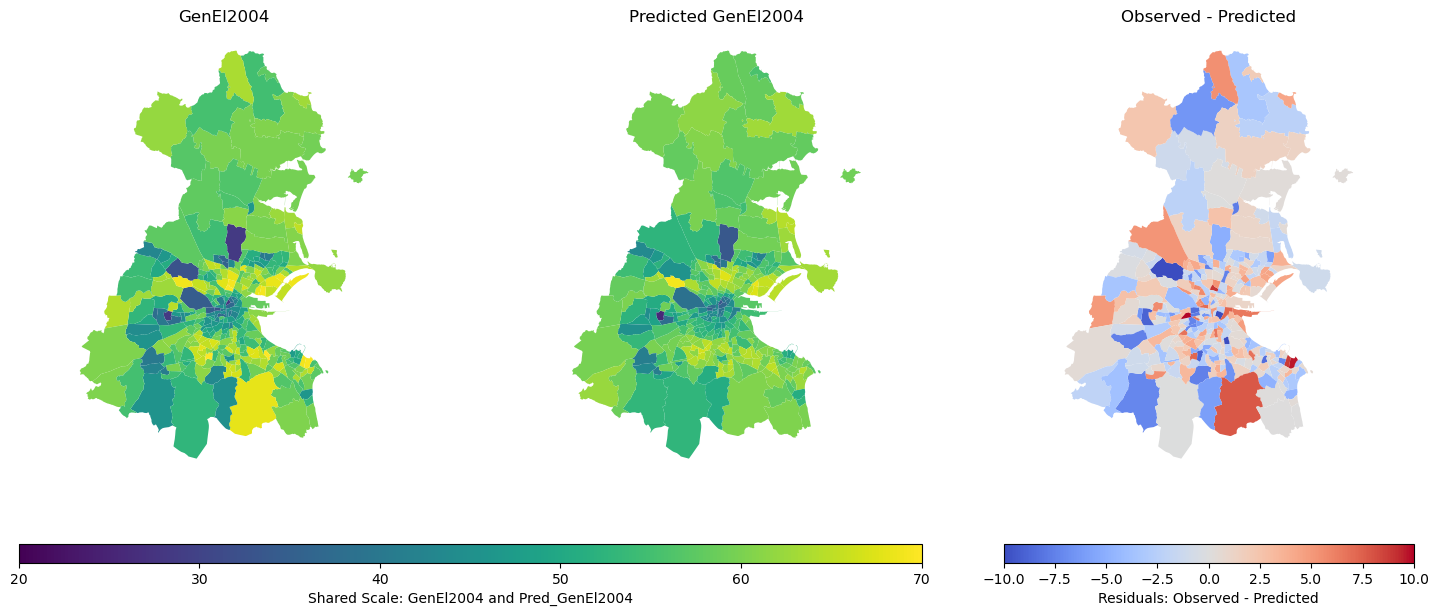

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import geopandas as gpd
from matplotlib.gridspec import GridSpec

# Create figure with GridSpec for better layout control
fig = plt.figure(figsize=(18, 8))
gs = GridSpec(3, 3, height_ratios=[12, 0.5, 0.5], hspace=0.4)  # Adjust height ratios for thinner color bars

# Subplots for maps
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Shared normalization for the first two plots
shared_norm = Normalize(
    vmin=min(gdf["GenEl2004"].min(), gdf["Pred_GenEl2004"].min()), 
    vmax=max(gdf["GenEl2004"].max(), gdf["Pred_GenEl2004"].max())
)

shared_norm = Normalize(
    vmin=20, 
    vmax=70
)

# Normalize for the residuals plot
residual_norm = Normalize(vmin=-10, vmax=10)

# Plotting each column
gdf.plot(column="GenEl2004", ax=ax1, norm=shared_norm, cmap="viridis", legend=False)
gdf.plot(column="Pred_GenEl2004", ax=ax2, norm=shared_norm, cmap="viridis", legend=False)
gdf.plot(column="Obs-Pred", ax=ax3, norm=residual_norm, cmap="coolwarm", legend=False)

# Titles for subplots
ax1.set_title("GenEl2004")
ax2.set_title("Predicted GenEl2004")
ax3.set_title("Observed - Predicted")

# Remove axes from subplots
for ax in [ax1, ax2, ax3]:
    ax.axis("off")

# Color bars
# Shared color bar for the first two subplots
cax_shared = fig.add_subplot(gs[1, :2])  # Spanning the first two columns
sm_shared = plt.cm.ScalarMappable(cmap="viridis", norm=shared_norm)
sm_shared.set_array([])
cbar_shared = fig.colorbar(sm_shared, cax=cax_shared, orientation="horizontal")
cbar_shared.set_label("Shared Scale: GenEl2004 and Pred_GenEl2004")

# Color bar for the residuals plot
cax_residual = fig.add_subplot(gs[1, 2])  # Third column for residuals
sm_residual = plt.cm.ScalarMappable(cmap="coolwarm", norm=residual_norm)
sm_residual.set_array([])
cbar_residual = fig.colorbar(sm_residual, cax=cax_residual, orientation="horizontal")
cbar_residual.set_label("Residuals: Observed - Predicted")

plt.show()


#### perform MGWR

In [11]:
from mgtwr.sel import SearchMGWRParameter
from mgtwr.model import MGWR

In [12]:
gdf = gpd.read_file("Dub.voter.geojson")
gdf.set_crs(epsg=29902, inplace=True, allow_override=True)

# get coordinates
coords = gdf[["X", "Y"]]

# extract independent variables
X = gdf[['DiffAdd', 'LARent', 'SC1', 'Unempl', 'LowEduc', 'Age18_24', 'Age25_44', 'Age45_64']]

# extract dependent variable
y = gdf[["GenEl2004"]]

In [13]:
?SearchMGWRParameter

Init signature:
SearchMGWRParameter(
    coords: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    X: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    y: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    kernel: str = 'exponential',
    fixed: bool = False,
    constant: bool = True,
    convert: bool = False,
    thread: int = 1,
)
Docstring:      Is the parent class of most models
File:           ~/miniconda3/envs/gwr_env/lib/python3.10/site-packages/mgtwr/sel.py
Type:           type
Subclasses:     

In [14]:
sel_multi = SearchMGWRParameter(coords, X, y, kernel='bisquare', fixed=False, thread=8)
bws = sel_multi.search(multi_bw_max=[len(coords) // 1], verbose=False, time_cost=True, tol_multi=1.0e-5)

time cost: 0:08:28.362


In [15]:
class sel_multi:
    def __init__(self, bws):
        self.bws = bws

selector = sel_multi(bws)
mgwr = MGWR(coords, X, y, selector, kernel='bisquare', fixed=False).fit()
print(mgwr.R2)

0.7554737718094519


/home/davidncu/miniconda3/envs/gwr_env/lib/python3.10/site-packages/mgtwr/model.py:319: RuntimeWarning: invalid value encountered in divide
  CCT[:, j] += ((pR[:, :, j] / self.X[:, j].reshape(-1, 1)) ** 2).sum(


In [16]:
gwr.R2

np.float64(0.8159608623449931)

In [17]:
mgwr.R2

np.float64(0.7554737718094519)